In [4]:
import os
import gdown
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

ModuleNotFoundError: No module named 'gdown'

## Download Data

In [2]:
url = 'https://drive.google.com/uc?id=1UnIk64eM2p32GdsaYIIan-09G0kE7Xmt'
output = 'data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1UnIk64eM2p32GdsaYIIan-09G0kE7Xmt
To: /content/data.zip
100%|██████████| 3.11G/3.11G [00:45<00:00, 69.1MB/s]


'data.zip'

In [3]:
!unzip data.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Fish_Dataset/Red Sea Bream/Red Sea Bream/00010.png  
  inflating: Fish_Dataset/Red Sea Bream/Red Sea Bream/00011.png  
  inflating: Fish_Dataset/Red Sea Bream/Red Sea Bream/00012.png  
  inflating: Fish_Dataset/Red Sea Bream/Red Sea Bream/00013.png  
  inflating: Fish_Dataset/Red Sea Bream/Red Sea Bream/00014.png  
  inflating: Fish_Dataset/Red Sea Bream/Red Sea Bream/00015.png  
  inflating: Fish_Dataset/Red Sea Bream/Red Sea Bream/00016.png  
  inflating: Fish_Dataset/Red Sea Bream/Red Sea Bream/00017.png  
  inflating: Fish_Dataset/Red Sea Bream/Red Sea Bream/00018.png  
  inflating: Fish_Dataset/Red Sea Bream/Red Sea Bream/00019.png  
  inflating: Fish_Dataset/Red Sea Bream/Red Sea Bream/00020.png  
  inflating: Fish_Dataset/Red Sea Bream/Red Sea Bream/00021.png  
  inflating: Fish_Dataset/Red Sea Bream/Red Sea Bream/00022.png  
  inflating: Fish_Dataset/Red Sea Bream/Red Sea Bream/00023.png  
  inflat

## Prepare Dataset and Dataloader

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
data_dir = 'Fish_Dataset'

classes = []

for directory in os.listdir(data_dir):
    if "." not in directory:
        classes.append(directory)
        
print(classes)

['Shrimp', 'Hourse Mackerel', 'Striped Red Mullet', 'Gilt-Head Bream', 'Trout', 'Black Sea Sprat', 'Red Mullet', 'Sea Bass', 'Red Sea Bream']


In [6]:
image_paths = []
image_classes = []
label_to_class = {}
for i, cls in enumerate(classes):
    label_to_class[i] = cls
    objects = os.listdir(os.path.join(data_dir, cls, cls))
    image_classes += len(objects) * [i]
    image_paths.extend(os.path.join(data_dir, cls, cls, i) for i in objects)

data = pd.DataFrame({'path':image_paths, 'class':image_classes})

In [7]:
data.head(3)

,path,class
0,Fish_Dataset/Shrimp/Shrimp/00647.png,0
1,Fish_Dataset/Shrimp/Shrimp/00147.png,0
2,Fish_Dataset/Shrimp/Shrimp/00520.png,0


In [8]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5),std=(0.5, 0.5, 0.5))
    ])

In [9]:
class MarketFishDataset(Dataset):
    def __init__(self, data, root_dir, transform=transforms.ToTensor()):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.data.iloc[idx, 0]
        image = Image.open(img_name)
        y_label = torch.tensor(self.data.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)
    
        return (image, y_label, img_name)

In [10]:
dataset = MarketFishDataset(
    data=data,
    root_dir=data_dir,
    transform=transform
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


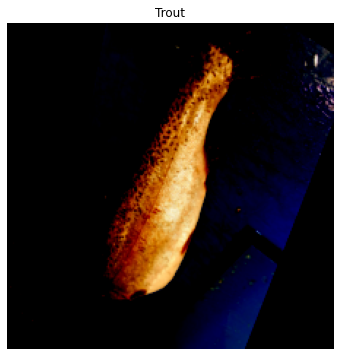

In [11]:
img, lab, img_name = dataset[4100]
plt.figure(figsize=(6, 6))
plt.imshow(img.numpy().transpose((1, 2, 0)))
plt.title(label_to_class[int(lab)])
plt.axis('off')
plt.show()

In [12]:
size = len(dataset)
print(f'Dataset size {size}')

Dataset size 9000


In [13]:
batch_size = 32
train_size = int(size * 0.8)
test_size = size - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_set,
                         batch_size=batch_size,
                         shuffle=True)

In [14]:
test_loader = DataLoader(dataset=test_set,
                         batch_size=batch_size,
                         shuffle=True)

In [15]:
batch_example = next(iter(train_loader))
print(f'Image batch size: {batch_example[0].shape}')
print(f'Label batch size: {batch_example[1].shape}')

Image batch size: torch.Size([32, 3, 224, 224])
Label batch size: torch.Size([32])


## Creating the Neural Network

In [16]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [26]:
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

In [17]:
def train(model, optimizer, criterion, epochs, train_loader, test_loader):
    loss_train, loss_test = [], []
    accuracy_train, accuracy_test = [], []

    for epoch in range(epochs):
        model.train()
        corrects = 0
        total = 0
        loss_list = []
        for images, labels, _ in tqdm(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            predictions = torch.max(outputs, 1)[1].to(DEVICE)

            total += len(labels)
            corrects += (predictions == labels).sum().item()
            loss_list.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        accuracy_train.append(100 * corrects / float(total))
        loss_train.append(np.mean(loss_list))

        model.eval()
        corrects = 0
        total = 0
        loss_list = []
        for images, labels, _ in tqdm(test_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            predict = torch.max(outputs.data, 1)[1].to(DEVICE)

            total += len(labels)
            corrects += (predict == labels).sum().item()
            loss_list.append(loss.item())

        accuracy_test.append(100 * corrects / float(total))
        loss_test.append(np.mean(loss_list))

        print(f"Epoch: {epoch + 1} | Train | Loss: {loss_train[-1]} | Accuracy: {accuracy_train[-1]}")
        print(f"Epoch: {epoch + 1} | Test | Loss: {loss_test[-1]} | Accuracy: {accuracy_test[-1]}\n")
    return accuracy_train, loss_train, accuracy_test, loss_test

### Simple CNN


In [18]:
class CNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(CNN, self).__init__()
        self.out_dim = out_dim
        
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, 8, 8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(8, 16, 5, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, stride=1, padding=0),
            nn.ReLU()
        )
        
        self.linear1 = nn.Linear(22 * 22 * 32, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, out_dim)
    
    def forward(self, x):
        conv = self.convs(x)
        flattened = conv.reshape(-1, 22 * 22 * 32)
        linear1 = F.relu(self.linear1(flattened))
        linear2 = self.linear2(linear1)
        out = self.linear3(linear2)
        return out

In [19]:
CUDA_LAUNCH_BLOCKING=1.

In [20]:
input_dim = dataset[0][0].shape[0] # number of channels (RGB - 3)
output_dim = len(classes) # number of classes
model = CNN(input_dim, output_dim).to(DEVICE)

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
# Запускать только при обучении моделей
# epochs = 8
# accuracy_train, loss_train, accuracy_test, loss_test = train(model, optimizer, criterion, epochs, train_loader, test_loader)

In [22]:
# torch.save(model.state_dict(), 'simple_cnn.pth')

In [23]:
# Загрузка весов модели
url = 'https://drive.google.com/uc?id=1ENDvYnc0A4Z3CHwVooqSDdKL9wMmuzC9'
output = 'simple_cnn.pth'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ENDvYnc0A4Z3CHwVooqSDdKL9wMmuzC9
To: /content/simple_cnn.pth
100%|██████████| 16.0M/16.0M [00:00<00:00, 87.4MB/s]


'simple_cnn.pth'

In [27]:
model.load_state_dict(torch.load('simple_cnn.pth'), map_location=map_location) 
model.eval()

RuntimeError: ignored

## Find required examples

In [ ]:
true_label = []
predicted_label = []
probits = []
for sample in tqdm(test_set):
    image, label, _ = sample
    predict = F.softmax(model(image[None, ...].to(DEVICE)), dim=1)
    true_label.append(int(label))
    predicted_label.append(np.argmax(predict.cpu().detach().numpy()))
    probits.append(predict.cpu().cpu().detach().numpy())

In [ ]:
index = np.arange(1800)
probits_arr = np.vstack(probits)
true_label_arr = np.vstack(true_label)
predicted_label_arr = np.vstack(predicted_label)

In [ ]:
np.random.seed(42)

In [ ]:
correctly_classified = (true_label_arr == predicted_label_arr).reshape(-1)
correct_prob = probits_arr[correctly_classified]
corr_index = index[correctly_classified]

sorted_prob = np.argsort(correct_prob.max(axis=1))
max_index_corr = corr_index[np.random.choice(sorted_prob[-300:], 2)]
min_index_corr = corr_index[np.random.choice(sorted_prob[:100], 2)]

In [ ]:
incorrectly_classified = (true_label_arr != predicted_label_arr).reshape(-1)
incorrect_prob = probits_arr[incorrectly_classified]
incorr_index = index[incorrectly_classified]

sorted_prob = np.argsort(incorrect_prob.max(axis=1))
max_index_incorr = incorr_index[np.random.choice(sorted_prob[-300:], 2)]
min_index_incorr = incorr_index[np.random.choice(sorted_prob[:100], 2)]

In [ ]:
# Нужные примеры достаем из test_set
# test_set[max_index_corr[0]]

In [ ]:
def print_examples(feature):
  for i in range(2):
    img, lab, img_name = test_set[feature[i]]
    image = Image.open(img_name)
    plt.figure(figsize=(6, 6))
    plt.imshow(np.array(image))
    plt.title(label_to_class[int(lab)])
    plt.axis('off')
    plt.show()

In [ ]:
print_examples(max_index_corr)

In [ ]:
print_examples(max_index_incorr)

In [ ]:
print_examples(min_index_corr)

In [ ]:
print_examples(min_index_incorr)

In [ ]:
## SHAP values

## SHAP values

In [ ]:
!pip install shap
import shap

In [ ]:
batch = next(iter(test_loader))
images, lab, img_name = batch
images.size()

In [ ]:
images = images.cuda()

In [ ]:
background = images[:10]
e = shap.DeepExplainer(model, background)
e

In [ ]:
## Correct answers

In [ ]:
test_images = images[[max_index_corr[1]]]
shap_values = e.shap_values(test_images)

# test_images=test_images.cpu()

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, -test_numpy)

In [ ]:
test_images = images[[min_index_corr[1]]]
shap_values = e.shap_values(test_images)

# test_images=test_images.cpu()

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, -test_numpy)

In [ ]:
## InCorrect answers

In [ ]:
test_images = images[[max_index_incorr[1]]]
shap_values = e.shap_values(test_images)

# test_images=test_images.cpu()

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, -test_numpy)

In [ ]:
test_images = images[[max_index_incorr[1]]]
shap_values = e.shap_values(test_images)



# test_images=test_images.cpu()

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, -test_numpy)

## LIME

In [2]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

In [ ]:
lime_explainer = lime_image.LimeImageExplainer()

In [ ]:
correct_test_images = images[[min_index_corr[1]]]
incorrect_test_images = images[[max_index_incorr[1]]]

__Правильная классификация__

In [ ]:
explanation = lime_explainer.explain_instance(correct_test_images[0].astype('double'), inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

__Неправильная классификация__

In [ ]:
explanation = lime_explainer.explain_instance(incorrect_test_images[0].astype('double'), inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))